<h1>Book Recommendation System based on book title</h1>

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\myste\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h3>Loading the dataset</h3>

In [2]:
data = pd.read_csv(r"C:\Users\myste\Downloads\archive\book_data.csv")

In [3]:
data['genres'] = data['genres'].str.split('|')

In [4]:
data_copy = data.copy()

<h3>Cleaning the data to automatically form keywords out of it</h3>

In [5]:
#Removing charahcters that have no representation in ASCII values
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)
#Convorting everything to lowercase for easy extraction and conparision of keywords
def make_lower_case(text):
    return text.lower()
#Removing stop words like The, Them etc. which don't matter for recommendation
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text
#Removing punctuations
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text
#Removing the html tags if any
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

data['book_title'] = data['book_title'].apply(_removeNonAscii)
data['book_title'] = data.book_title.apply(func = make_lower_case)
data['book_title'] = data.book_title.apply(func = remove_stop_words)
data['book_title'] = data.book_title.apply(func=remove_punctuation)
data['book_title'] = data.book_title.apply(func=remove_html)

In [6]:
data.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,hunger games,"[Young Adult, Fiction, Science Fiction, Dystop...",https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,harry potter order phoenix,"[Fantasy, Young Adult, Fiction]",https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,kill mockingbird,"[Classics, Fiction, Historical, Historical Fic...",https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,pride prejudice,"[Classics, Fiction, Romance]",https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.58,4281268,97991,twilight,"[Young Adult, Fantasy, Romance, Paranormal, Va...",https://images.gr-assets.com/books/1361039443l...


In [7]:
keywords = data['book_title'].to_numpy()

In [8]:
primaryTitle = data_copy['book_title'].to_numpy()

<h3>Making a dataset out of keywords and book titles </h3>

In [9]:
df = pd.DataFrame(data=np.column_stack((primaryTitle,keywords)),columns=['primaryTitle','keywords'])

In [10]:
df

,primaryTitle,keywords
0,The Hunger Games,hunger games
1,Harry Potter and the Order of the Phoenix,harry potter order phoenix
2,To Kill a Mockingbird,kill mockingbird
3,Pride and Prejudice,pride prejudice
4,Twilight,twilight
...,...,...
54296,Taking the Field: A Fan's Quest to Run the Tea...,taking field fan s quest run team loves
54297,"The Baseball Talmud: Koufax, Greenberg, and th...",baseball talmud koufax greenberg quest ultimat...
54298,"Wilpon's Folly - The Story of a Man, His Fortu...",wilpon s folly story man fortune new york mets
54299,He Wanted the Moon: The Madness and Medical Ge...,wanted moon madness medical genius dr perry ba...


<h3>Tokenizing the keywords for further processing</h3>

In [11]:
keywords = [word_tokenize(keyword) for keyword in keywords]

In [12]:
keywords

[['hunger', 'games'],
 ['harry', 'potter', 'order', 'phoenix'],
 ['kill', 'mockingbird'],
 ['pride', 'prejudice'],
 ['twilight'],
 ['book', 'thief'],
 ['chronicles', 'narnia'],
 ['animal', 'farm'],
 ['gone', 'wind'],
 ['j',
  'r',
  'r',
  'tolkien',
  '4',
  'book',
  'boxed',
  'set',
  'hobbit',
  'lord',
  'rings'],
 ['fault', 'stars'],
 ['hitchhiker', 's', 'guide', 'galaxy'],
 ['giving', 'tree'],
 ['wuthering', 'heights'],
 ['da', 'vinci', 'code'],
 ['memoirs', 'geisha'],
 ['alice', 's', 'adventures', 'wonderland', 'looking', 'glass'],
 ['picture', 'dorian', 'gray'],
 ['les', 'misrables'],
 ['divergent'],
 ['jane', 'eyre'],
 ['romeo', 'juliet'],
 ['lord', 'flies'],
 ['alchemist'],
 ['crime', 'punishment'],
 ['ender', 's', 'game'],
 ['perks', 'wallflower'],
 ['city', 'bones'],
 ['help'],
 ['great', 'gatsby'],
 ['time', 'traveler', 's', 'wife'],
 ['charlotte', 's', 'web'],
 ['anne', 'green', 'gables'],
 ['mice', 'men'],
 ['dracula'],
 ['brave', 'new', 'world'],
 ['one', 'hundred', '

<h3> Vectorizing the words from tokens to vectors</h3>

In [13]:
def get_vectors(text):
    vectorizer = CountVectorizer(text)
    X = vectorizer.fit_transform(text).toarray()
    return(X)
vectors = get_vectors(df.keywords.tolist())

<h3>Function to check cosine similarity and recommend books based on similarity in titles</h3>

In [14]:
def cosine_recommender(title, number_of_hits=5):
    book_index = df[df.primaryTitle == title].index.values[0]
    cosines = []
    for i in range(len(vectors)):
        vector_list = [vectors[book_index], vectors[i]]
        cosines.append(cosine_similarity(vector_list)[0,1])
    cosines = pd.Series(cosines)
    index = cosines.nlargest(number_of_hits+1).index
    matches = df.loc[index]
    for match,score in zip(matches['primaryTitle'][1:],cosines[index][1:]):
        print(match,score )
    rec = data_copy[['book_title', 'image_url']].iloc[index]
    for i in rec['image_url']:
        response = requests.get(i)
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)

<h3>Results for Harry Potter</h3>

Harry Potter and the Order of the Phoenix (Harry Potter, #5, Part 1) 0.9045340337332909
Selections from Harry Potter and the Order of the Phoenix: Piano Solos 0.7559289460184544
Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5) 0.6030226891555273
The Harry Potter Collection 1-4 0.5773502691896258
Harry Potter Collection 0.5773502691896258


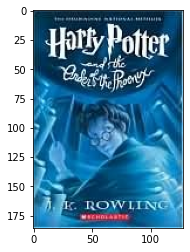

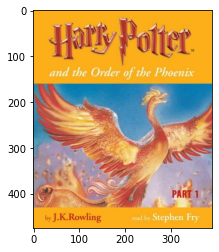

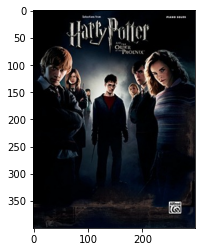

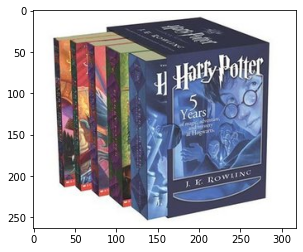

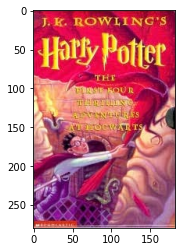

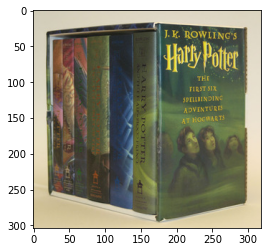

In [15]:
cosine_recommender('Harry Potter and the Order of the Phoenix')

<h3>Results for Captains and the Kings </h3>

A Clash of Kings 0.4999999999999999
The Way of Kings 0.4999999999999999
The Game of Kings 0.4999999999999999
The Kings of Clonmel 0.4999999999999999
Kings Rising 0.4999999999999999


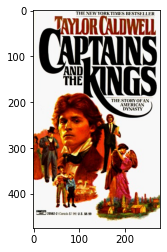

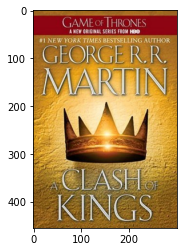

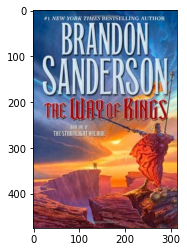

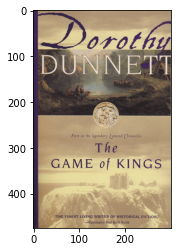

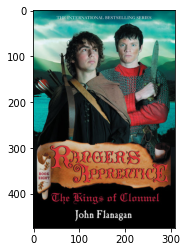

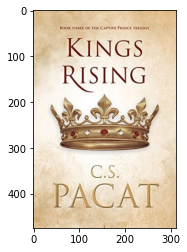

In [16]:
cosine_recommender('Captains and the Kings')